<a href="https://colab.research.google.com/github/jasreman8/Single-Agent-Systems/blob/main/E_Commerce_Customer_Support_Specialist_using_Pre_Built_and_Custom_ReAct_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Illustrate how functions can be used as tools in a single-agent system
- Implement the ReAct paradigm for single-agent systems

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langgraph==0.3.21

In [2]:
import uuid

from langchain_openai import ChatOpenAI
from typing import List, Annotated, TypedDict

from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langchain.tools import StructuredTool

from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.graph.message import add_messages

from google.colab import userdata

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)

- ReAct agents follow a cycle of reasoning before acting, ensuring decisions are structured. They use functions as tools, making complex tasks more interpretable and modular.

# Business Scenario



**Domain: E-commerce Retail**

**Business Problem:** Automating initial customer support interactions regarding order status, product information, returns, and escalations. The goal is to resolve common queries quickly using tools and escalate complex issues when necessary.

In this notebook, we implement a conversational AI agent designed for e-commerce customer support using the LangGraph library. The agent is built as a state machine (a graph) that can interact with a user, understand their request, and utilize a set of predefined "tools" to perform specific tasks like checking order status, product inventory, initiating returns, or escalating complex issues.

The core idea is to leverage a LLM to understand the user's intent and decide which tool (if any) is needed to fulfill the request. Note that we have built similar workflows before (the router pattern). The difference here is that the decision on which tool to pick and execute is autonomously taken by the reasoning capabilities of the agent.


The agents we build are based on the ReAct (Reason + Act) prompting strategy. ReAct allows an LLM to work through problems step-by-step: it thinks about what to do next ("Thought"), chooses an action, often using a tool ("Action"), sees the result ("Observation"), and repeats this cycle until it finds the final answer. Recent LLMs (e.g., GPT 4o, GPT 4o mini) were trained to identify function call sequences to achieve a goal and have largely removed the need to formulate detailed prompts that execute the Thought - Action - Observation loop. Since function calling is native to these LLMs, they directly formulate a sequence of function calls and assemble the arguments required to execute these functions as outputs (i.e., ToolMessage instead of AIMessage).

We'll show two ways to create these ReAct agents:
- Using the shortcut: We'll use LangChain's `create_react_agent` function. It's a quick way to connect tools to an LLM and get a working agent.
- Building it ourselves: We'll then assemble the agent piece by piece. This method helps understand exactly how the thought-action-observation loop (which `create_react_agent` hides) works internally by repeatedly calling tools.

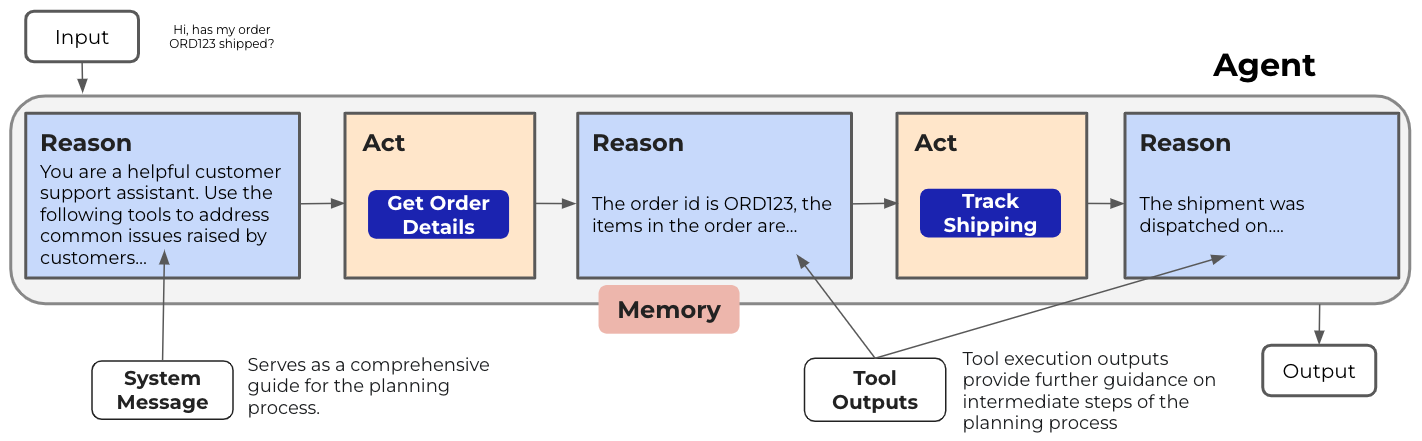

# Approach 1: Pre-built ReAct Agent

In another notebook, we built an agent as a combination of LLM calls and tool execution. In this section, we illustrate an alternative way to build the e-commerce customer support agent. Instead of using the explicit graph-building approach of LangGraph, it utilizes LangChain's higher-level `create_react_agent` function.

 - This code defines four tool functions (for order details, inventory, returns, and escalation) and then passes them directly to `create_react_agent` along with the initialized LLM.
 - The resulting agent object encapsulates the ReAct logic, automatically handling the interaction loop between the LLM (reasoning) and the tools (acting).
 - Finally, the script shows how to invoke this agent with a user query and retrieve the final response.

Let us begin by defining a set of four functions that will delineate the functionality of the agent. These functions simulate the core business logic required for the e-commerce support agent:
1) fetching order data,
2) checking stock,
3) processing returns, and
4) handling escalations.

- Docstrings: The docstrings of the functions are crucial. The ReAct agent heavily relies on these descriptions to understand what each tool does and when it should be used to solve the user's request.
- Inputs/Outputs: They take specific arguments (like `order_id`, `sku`) and return a string result based on the simulated operation.

In [4]:
def get_order_details(order_id: str) -> str:
    """
    Retrieves the status, items, and shipping address for a given order ID.
    Use this tool when a customer asks about their order status or details.
    """
    print(f"--- Tool: get_order_details --- Input: {order_id=}")

    # --- Simulated Database Lookup ---
    orders_db = {
        "ORD123": {"status": "Shipped", "items": ["Laptop", "Mouse"], "address": "123 Main St", "tracking_id": "TRK456"},
        "ORD456": {"status": "Processing", "items": ["Keyboard"], "address": "456 Oak Ave", "tracking_id": None},
        "ORD789": {"status": "Delivered", "items": ["Monitor"], "address": "789 Pine Ln", "tracking_id": "TRK123"},

    }

    details = orders_db.get(order_id)

    if details:
        return f"Order {order_id} Status: {details['status']}. Items: {', '.join(details['items'])}. Shipping Address: {details['address']}. Tracking: {details.get('tracking_id', 'N/A')}"
    else:
        return f"Order ID '{order_id}' not found."

In [5]:
def check_product_inventory(sku: str) -> str:
    """
    Checks the current stock level for a specific product SKU.
    Use this tool when a customer asks about product availability.
    """
    print(f"--- Tool: check_product_inventory --- Input: {sku=}")
    # --- Simulated Inventory Check ---
    inventory_db = {
        "LPTP001": 50,  # Laptop
        "MSE002": 120, # Mouse
        "KBD003": 0,   # Keyboard (Out of stock)
        "MON004": 35,  # Monitor
    }
    stock = inventory_db.get(sku)
    if stock is not None:
        availability = "In Stock" if stock > 0 else "Out of Stock"
        return f"Product SKU '{sku}' is currently {availability}. Quantity available: {stock}."
    else:
        return f"Product SKU '{sku}' not found in inventory system."

In [6]:
def initiate_return(order_id: str, sku: str, reason: str) -> str:
    """
    Initiates a return request for a specific item (SKU) from a given order ID.
    Use this tool when a customer explicitly states they want to return an item.
    Requires the order ID, the product SKU, and the reason for return.
    """
    print(f"--- Tool: initiate_return --- Input: {order_id=}, {sku=}, {reason=}")
    # --- Simulated Return Process ---
    # In a real system, this would create a Return Merchandise Authorization (RMA)
    return_id = f"RMA-{uuid.uuid4().hex[:6].upper()}"
    # Basic check if order exists (using the same dummy DB)
    if order_id in {"ORD123", "ORD456", "ORD789"}:
        return f"Return initiated for SKU '{sku}' from order '{order_id}'. Reason: '{reason}'. Your return ID is {return_id}. Instructions will be emailed shortly."
    else:
        return f"Could not initiate return. Order ID '{order_id}' not found."

In [7]:
def escalate_issue(conversation_summary: str, reason_for_escalation: str) -> str:
    """
    Escalates the customer's issue to a human support agent.
    Use this tool ONLY when the automated system cannot resolve the query after trying other tools,
    or if the customer's request is too complex or requires human intervention (e.g., complaints, unusual requests).
    Provide a summary of the conversation and the reason for escalation.
    """
    print(f"--- Tool: escalate_issue --- Input: {conversation_summary=}, {reason_for_escalation=}")
    # --- Simulated Escalation ---
    ticket_id = f"ESC-{uuid.uuid4().hex[:6].upper()}"
    print(f"\n*** Escalation Triggered ***")
    print(f"Summary: {conversation_summary}")
    print(f"Reason: {reason_for_escalation}")
    print(f"Ticket ID: {ticket_id}")
    print(f"***************************\n")
    return f"I understand this requires further assistance. I have escalated your issue to our support team. Your ticket ID is {ticket_id}. An agent will contact you shortly."

 - Functions act as tools that the agent can use to perform tasks.

To steer the behavior of the ReAct agent, let us implement a detailed system prompt.

In [8]:
system_prompt = """
You are a friendly and highly capable AI customer support assistant for an online retailer.
Your primary function is to help customers with common issues.
You have access to tools for checking order status, product inventory, initiating returns, and escalating complex cases.
Analyze the customer's query carefully. If it matches a tool's capability (like checking order 'ORD123' status, checking stock for 'KBD003', or returning 'MSE002' from order 'ORD123' due to 'defect'), use the appropriate tool.
Remember that more than one tool might be necessary to address complex queries.
If the query is complex, requires information not available via tools, use the escalation tool. Provide clear and concise answers based on the tool results or inform the customer about the escalation.

Your final output should be a direct and helpful response to the customer addressing their query.
This response should either contain the information requested (e.g., order status, stock level), confirm the action taken (e.g., return initiated with ID), or confirm escalation (with ticket ID)."
"""

In [9]:
agent = create_react_agent(
    model=llm,
    tools=[get_order_details, check_product_inventory, initiate_return, escalate_issue],
    prompt=system_prompt
)

The above function is the core of this approach. The `create_react_agent` function is a high-level factory provided by LangChain.
- It takes the initialized language model (`model=llm`) which will perform the reasoning steps.
- It takes a list of tools that the agent is allowed to use (`tools=[...]`). These are the actions the agent can perform.
- Internal Mechanism: Behind the scenes, `create_react_agent` sets up a specific prompt template designed for the ReAct strategy using our system message. When invoked, the resulting agent object will:
    1. Present the current conversation and available tools to the LLM.
    2. Ask the LLM to generate a "Thought" process and decide on an "Action" (a tool call with arguments) or provide a "Final Answer".
    3. Parse the LLM's output. If an Action is specified, it executes the corresponding tool function from the tools list.
    4. Formats the tool's output as an "Observation".
    5. Feeds the Observation back into the LLM prompt along with the history.
    6. Repeats steps 2-5 until the LLM generates a "Final Answer".

This function abstracts away the explicit state management and node/edge definition seen in LangGraph, providing a quicker way to set up a standard tool-using agent loop.

In [10]:
graph = agent.get_graph().draw_mermaid_png(output_file_path='react-agent.png')

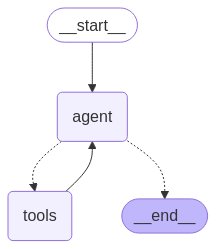

In [11]:
user_input = "Hi, can you tell me the status of my order ORD123?"

messages_input = [HumanMessage(content=user_input)]

In [12]:
response = agent.invoke({"messages": messages_input}) # executing the agent created by create_react_agent.

--- Tool: get_order_details --- Input: order_id='ORD123'


In [13]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

Your order **ORD123** has been shipped. Here are the details:

- **Items**: Laptop, Mouse
- **Shipping Address**: 123 Main St.
- **Tracking Number**: TRK456

If you have any more questions or need further assistance, feel free to ask!


In the code block above:
- `user_input` and `messages_input`: Prepare the user's query in the standard LangChain message format, identical to the LangGraph example.
- `agent.invoke({"messages": messages_input})`: This executes the agent created by create_react_agent.
    - It passes the initial message(s) to the agent.
    - The agent internally runs the ReAct loop (Thought -> Action -> Observation -> ...) until it determines a final answer. This might involve calling get_order_details based on the input query.
    - `invoke` waits for the entire ReAct chain to complete.
- `response = ...`: The `invoke` method returns a dictionary containing the results of the agent's execution. Based on the subsequent code (`response['messages']`...), this dictionary is expected to contain the full list of messages exchanged during the ReAct process (Human input, AI thoughts/actions, Tool observations, final AI answer).
- `final_ai_message = response['messages'][-1].content`: Extracts the content of the very last message in the history, which represents the agent's final output to the user.

Let us inspect the full trace of the messages that the agent executed during this invocation.

In [14]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Hi, can you tell me the status of my order ORD123?
================================== Ai Message ==================================
Tool Calls:
  get_order_details (call_7Nv9EIdxjXqtGBjzG39sCwH1)
 Call ID: call_7Nv9EIdxjXqtGBjzG39sCwH1
  Args:
    order_id: ORD123
================================= Tool Message =================================
Name: get_order_details

Order ORD123 Status: Shipped. Items: Laptop, Mouse. Shipping Address: 123 Main St. Tracking: TRK456
================================== Ai Message ==================================

Your order **ORD123** has been shipped. Here are the details:

- **Items**: Laptop, Mouse
- **Shipping Address**: 123 Main St.
- **Tracking Number**: TRK456

If you have any more questions or need further assistance, feel free to ask!


We can observe from the trace above that the first response from the AI message is not to answer the question but to assemble the function `get_order_details` with the correct input argument. This function is then executed and a `Tool Message` is created. Finally, the LLM looks at all the three mesages (HumanMessage, AIMessage and ToolMessage) to formulate its final answer.

Let us look at one more example.

In [15]:
user_input = "I want to return the mouse (MSE002) from order ORD123 because it's faulty."

messages_input = [HumanMessage(content=user_input)]

In [16]:
response = agent.invoke({"messages": messages_input})

--- Tool: initiate_return --- Input: order_id='ORD123', sku='MSE002', reason='defect'


In [17]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

Your return for the mouse (SKU: MSE002) from order ORD123 has been successfully initiated due to a defect. Your return ID is RMA-F2BAA6. Instructions for the return will be emailed to you shortly. If you have any further questions, feel free to ask!


In [18]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

I want to return the mouse (MSE002) from order ORD123 because it's faulty.
================================== Ai Message ==================================
Tool Calls:
  initiate_return (call_Vfv4lyiiVwgv2ogWF6gsgOj5)
 Call ID: call_Vfv4lyiiVwgv2ogWF6gsgOj5
  Args:
    order_id: ORD123
    sku: MSE002
    reason: defect
================================= Tool Message =================================
Name: initiate_return

Return initiated for SKU 'MSE002' from order 'ORD123'. Reason: 'defect'. Your return ID is RMA-F2BAA6. Instructions will be emailed shortly.
================================== Ai Message ==================================

Your return for the mouse (SKU: MSE002) from order ORD123 has been successfully initiated due to a defect. Your return ID is RMA-F2BAA6. Instructions for the return will be emailed to you shortly. If you have any further questions, feel free to ask!


Once again, the above trace indicates that the first output from the LLM is an AIMessage that picks the correct function and values of its arguments. Execution of this function is captured in the ToolMessage.

Let us now look at a compound query - one that requires more than one tool call to answer.

In [19]:
user_input = """
Hi, I need to return the Keyboard (SKU KBD003) from my order ORD456 because it arrived broken.
Can you please start that process?
Also, I'd like to order a replacement - could you check if the Keyboard (KBD003) is currently in stock?
"""

messages_input = [HumanMessage(content=user_input)]

In [20]:
response = agent.invoke({"messages": messages_input})

--- Tool: initiate_return --- Input: order_id='ORD456', sku='KBD003', reason='defect'--- Tool: check_product_inventory --- Input: sku='KBD003'



In [21]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

I've initiated the return process for the Keyboard (SKU KBD003) from your order ORD456 due to it arriving broken. Your return ID is RMA-953224, and you will receive instructions via email shortly.

However, I checked the availability for the Keyboard (KBD003), and unfortunately, it is currently out of stock. If you would like assistance with anything else or to explore alternative products, please let me know!


In [22]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================


Hi, I need to return the Keyboard (SKU KBD003) from my order ORD456 because it arrived broken.
Can you please start that process?
Also, I'd like to order a replacement - could you check if the Keyboard (KBD003) is currently in stock?

================================== Ai Message ==================================
Tool Calls:
  initiate_return (call_89bVR8yi84xEpoqENIRZke4o)
 Call ID: call_89bVR8yi84xEpoqENIRZke4o
  Args:
    order_id: ORD456
    sku: KBD003
    reason: defect
  check_product_inventory (call_GzBLf3kTACR7A1qmlNWGgHa5)
 Call ID: call_GzBLf3kTACR7A1qmlNWGgHa5
  Args:
    sku: KBD003
================================= Tool Message =================================
Name: initiate_return

Return initiated for SKU 'KBD003' from order 'ORD456'. Reason: 'defect'. Your return ID is RMA-953224. Instructions will be emailed shortly.
================================= Tool Message =====================

# Approach 2: Custom ReAct Agent

Let us now implement all the individual aspects of the ReAct agent flow that are abstracted away by the `create_react_agent` function.

Specifically, we will use LangGraph to create the same agent as in the previous section.

However, we will orchestrate the ReAct flow:
1) calling the LLM,
2) executing tools repeatedly based on the LLM's decision,
3) feeding the tool results back to the LLM for formulating a response, and
4) managing the conversation history.

We use the same four tools from approach 1 simulating common e-commerce support functions and wire them into a LangGraph workflow.

In [23]:
class AgentState(TypedDict):
    # The 'messages' field holds the list of messages.
    # Using add_messages ensures that when new messages are returned
    # from nodes, they are appended to the existing list rather than
    # overwriting it. This is crucial for maintaining conversation history.
    messages: Annotated[list, add_messages]

# add_messages instructs LangGraph to append new node-returned messages to the existing messages list rather than replacing it.

The above code block defines the structure of the data that will persist and be passed between nodes in the graph.

- `AgentState` is a dictionary-like object.
- `messages`: A key in the state dictionary. Its value must be a list.
- `Annotated[list, add_messages]`: This is crucial. It tells LangGraph that the messages field is a list and that when a node returns a new list of messages for this key, those messages should be appended to the existing list using the add_messages function, preserving the conversation flow.

## Tool Definition

This section defines the specific capabilities or "tools" that the e-commerce customer support agent can utilize. The `StructuredTool` abstraction used in this section treats the Python function itself as the single source of truth for the tool's definition. It reduces boilerplate code by removing the need for separate schema classes and consolidates the tool's logic, description, and input structure within the function definition.

1. Core Logic in Functions: Standard Python functions like `get_order_details`, `check_product_inventory`, `initiate_return`, and `escalate_issue` are defined. Each function contains the actual business logic for the tool - in this case, simulating interactions with e-commerce backend systems (database lookups, return initiation, etc.).

2. Type Hinting for Schema: The function signatures use standard Python type hints (e.g., `order_id: str, sku: str, reason: str`). These type hints are essential as `StructuredTool.from_function()` inspects them to automatically determine the expected data types for each input argument.

3. Docstrings for Description and Argument Context:
    - Tool Description: The main docstring ("""...""") of each function is crucial. It serves as the primary description of the tool provided to the LLM. The LLM heavily relies on this description to understand what the tool does, when it should be used, and the overall context.
    - Argument Understanding: While not explicitly shown in this specific code's docstrings, StructuredTool can also often infer argument descriptions if standard formats (like Google or Numpydoc style Args sections) are used within the docstring. In this case, the LLM primarily uses the parameter names from the function signature (`order_id, sku, reason`, etc.) combined with the overall tool description to understand how to structure its arguments.

4. `StructuredTool.from_function()` - The Core Mechanism:
    - After each function definition, `StructuredTool.from_function(your_function_name)` is called (e.g., `order_tool = StructuredTool.from_function(get_order_details)`).
    - This class method automatically creates a fully formed LangChain tool object by:
        - Inspecting the Function: It analyzes the provided function (`get_order_details`).
        - Setting Tool Name: It defaults to using the function's name (`get_order_details`) as the tool's name, which the LLM will use.
        - Setting Tool Description: It uses the function's main docstring as the tool's description.
        - Inferring args_schema: It automatically generates the input schema (args_schema) by looking at the function's parameters, their names, and their type hints. This eliminates the need to manually define a separate Pydantic BaseModel for inputs. It naturally handles functions with single or multiple arguments.

5. Tools List: Finally, the created StructuredTool objects (`order_tool`, `inventory_tool`, `return_tool`, `escalate_tool`) are collected into the tools list. This list contains the ready-to-use tool objects that will be provided to the LLM (via binding) and the `ToolNode` for execution within the LangGraph workflow.

### Tool 1: Retrieve Order Details

In [24]:
def get_order_details(order_id: str) -> str:
    """
    Retrieves the status, items, and shipping address for a given order ID.
    Use this tool when a customer asks about their order status or details.
    """
    print(f"--- Tool: get_order_details --- Input: {order_id=}")

    # --- Simulated Database Lookup ---
    orders_db = {
        "ORD123": {"status": "Shipped", "items": ["Laptop", "Mouse"], "address": "123 Main St", "tracking_id": "TRK456"},
        "ORD456": {"status": "Processing", "items": ["Keyboard"], "address": "456 Oak Ave", "tracking_id": None},
        "ORD789": {"status": "Delivered", "items": ["Monitor"], "address": "789 Pine Ln", "tracking_id": "TRK123"},

    }

    details = orders_db.get(order_id)

    if details:
        return f"Order {order_id} Status: {details['status']}. Items: {', '.join(details['items'])}. Shipping Address: {details['address']}. Tracking: {details.get('tracking_id', 'N/A')}"
    else:
        return f"Order ID '{order_id}' not found."

In [25]:
order_tool = StructuredTool.from_function(get_order_details)

### Tool 2: Check Product Inventory

In [26]:
def check_product_inventory(sku: str) -> str:
    """
    Checks the current stock level for a specific product SKU.
    Use this tool when a customer asks about product availability.
    """
    print(f"--- Tool: check_product_inventory --- Input: {sku=}")
    # --- Simulated Inventory Check ---
    inventory_db = {
        "LPTP001": 50,  # Laptop
        "MSE002": 120, # Mouse
        "KBD003": 0,   # Keyboard (Out of stock)
        "MON004": 35,  # Monitor
    }
    stock = inventory_db.get(sku)
    if stock is not None:
        availability = "In Stock" if stock > 0 else "Out of Stock"
        return f"Product SKU '{sku}' is currently {availability}. Quantity available: {stock}."
    else:
        return f"Product SKU '{sku}' not found in inventory system."

In [27]:
inventory_tool = StructuredTool.from_function(check_product_inventory)

### Tool 3: Initiate Return

In [28]:
def initiate_return(order_id: str, sku: str, reason: str) -> str:
    """
    Initiates a return request for a specific item (SKU) from a given order ID.
    Use this tool when a customer explicitly states they want to return an item.
    Requires the order ID, the product SKU, and the reason for return.
    """
    print(f"--- Tool: initiate_return --- Input: {order_id=}, {sku=}, {reason=}")
    # --- Simulated Return Process ---
    # In a real system, this would create a Return Merchandise Authorization (RMA)
    return_id = f"RMA-{uuid.uuid4().hex[:6].upper()}"
    # Basic check if order exists (using the same dummy DB)
    if order_id in {"ORD123", "ORD456", "ORD789"}:
        return f"Return initiated for SKU '{sku}' from order '{order_id}'. Reason: '{reason}'. Your return ID is {return_id}. Instructions will be emailed shortly."
    else:
        return f"Could not initiate return. Order ID '{order_id}' not found."

In [29]:
return_tool = StructuredTool.from_function(initiate_return)

### Tool 4: Escalate Issue

In [30]:
def escalate_issue(conversation_summary: str, reason_for_escalation: str) -> str:
    """
    Escalates the customer's issue to a human support agent.
    Use this tool ONLY when the automated system cannot resolve the query after trying other tools,
    or if the customer's request is too complex or requires human intervention (e.g., complaints, unusual requests).
    Provide a summary of the conversation and the reason for escalation.
    """
    print(f"--- Tool: escalate_issue --- Input: {conversation_summary=}, {reason_for_escalation=}")
    # --- Simulated Escalation ---
    ticket_id = f"ESC-{uuid.uuid4().hex[:6].upper()}"
    print(f"\n*** Escalation Triggered ***")
    print(f"Summary: {conversation_summary}")
    print(f"Reason: {reason_for_escalation}")
    print(f"Ticket ID: {ticket_id}")
    print(f"***************************\n")
    return f"I understand this requires further assistance. I have escalated your issue to our support team. Your ticket ID is {ticket_id}. An agent will contact you shortly."

In [31]:
escalate_tool = StructuredTool.from_function(escalate_issue)

In [32]:
tools = [order_tool, inventory_tool, return_tool, escalate_tool]

## Agent Construction

In [33]:
llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
# This gives LLM the power to decide whether to call a tool, which tool to call, and generate structured arguments for that tool automatically.

In the code above, `llm.bind_tools(tools, tool_choice="auto")`: This connects the defined tools list to the LLM instance. The LLM can now "see" these tools and their descriptions/schemas. `tool_choice="auto"` allows the LLM to decide whether to call a tool, which tool to call, and what arguments to pass based on the conversation context.

Most importantly, this tool-aware LLM automatically reasons about the sequence of tool executions needed to address the user query and formats these executions appropriately.

In [34]:
# Define the node that will call the LLM
def call_model(state: AgentState):

    """Invokes the LLM with the current message history."""
    print("---LLM NODE---")

    messages = state['messages']

    # Call the LLM with the message history and the bound tools

    response = llm_with_tools.invoke(messages)

    # Return the response message to be appended to the state
    # Thanks to add_messages, this AIMessage will be appended

    return {"messages": [response]}

The above code defines the agent node.
- It takes the current `AgentState` as input.
- Retrieves the message history (`state['messages']`).
- Invokes the LLM (`llm_with_tools`) with the message history. The LLM might respond with a text message or with instructions to call one or more tools (`tool_calls`).
- Returns a dictionary `{"messages": [response]}`. This response (an AIMessage, potentially with tool_calls) will be added to the state's messages list thanks to `add_messages`.

In [35]:
tool_node = ToolNode(tools)

The above code creates an instance of the pre-built `ToolNode`. This node is responsible for executing the actual tool functions when the LLM requests them. It automatically handles parsing the `tool_calls` from the LLM's message, calling the correct Python function from the tools list with the right arguments, and packaging the results as `ToolMessage` objects.

In [36]:
def should_continue(state: AgentState):
    """Determines whether to continue the loop or end."""
    print("--- Condition: should_continue ---")
    last_message = state['messages'][-1]
    # If the LLM made tool calls, route to the tool node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("Decision: Continue to action node")
        return "continue"
    # Otherwise, end the graph execution
    else:
        print("Decision: End graph")
        return "end"

The above code defines the logic for conditional branching after the agent node runs.
- It inspects the last message added to the state (`state['messages'][-1]`).
- If that message contains `tool_calls` (meaning the LLM decided to use a tool), it returns the string "continue".
- Otherwise (the LLM provided a final answer or needs more input), it returns the string "end".

Note that the `call_model` and `should_continue` functions together implement the ReAct core loop. Let us see how.

- The ReAct paradigm operates on a cycle:

    Reason: The LLM analyzes the current situation (conversation history, goal) and thinks about the next step.

    Act: Based on the reasoning, the LLM decides to take an action, typically by choosing a tool and its arguments.

    Observe: The result of the action (tool output) is obtained and added to the context.

    This cycle repeats until the LLM reasons that it has enough information to provide a final answer.

- `call_model` as the "Reason" Step: In the LangGraph setup, the call_model node executes the LLM. This is where the "Reason" part of ReAct happens. The LLM examines the messages in the current state and decides:

    - Option A: It needs more information or needs to perform an action. It outputs a message containing tool_calls (This signifies the intent to "Act").

    - Option B: It has enough information and can formulate a final response. It outputs a regular message without tool_calls.

- `should_continue` as the "Act vs. Final Answer" Decision Point: The should_continue function runs immediately after the call_model ("Reason") step. Its sole purpose is to inspect the LLM's decision (represented by the presence or absence of tool_calls in the latest message) and route the execution accordingly:

    - If `tool_calls` exist: This means the LLM decided to "Act". should_continue returns "continue". The graph then transitions to the action node (the `ToolNode`), which performs the actual "Act" by executing the specified tool(s). After the tool runs, its output (the "Observation") is added to the state, and the flow loops back to call_model for the next "Reason" step. This directly implements the continuation of the ReAct cycle.

    - If `tool_calls` do not exist: This means the LLM's "Reason" step concluded that it could provide a "Final Answer" without needing further actions. should_continue returns "end". The graph transitions to the END state, terminating the ReAct loop for this particular user query.

In essence, `should_continue` acts as the crucial conditional gatekeeper within the LangGraph structure that determines whether to proceed with the "Act" step (and subsequent "Observation") of the ReAct cycle or to conclude the process because the "Reason" step yielded a final answer. It translates the LLM's decision (implicit in its output format) into explicit graph navigation.

In [37]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("reason", call_model) # The LLM node
workflow.add_node("act", tool_node) # The node that executes tools

# Define edges
workflow.add_edge(START, "reason") # Start with the reason node

# Conditional edge from 'reason' to 'act' or END
workflow.add_conditional_edges(
    "reason",        # Starting node
    should_continue,# Function to decide the route
    {
        "continue": "act", # If "continue", go to action node
        "end": END            # If "end", finish the graph
    }
)

# Edge from 'act' back to 'plan'
# After executing tools, the results (ToolMessages) are added to the state.
# We loop back to the plan node to let the LLM process the tool results.
workflow.add_edge("act", "reason")

The above code initializes the agentic workflow connecting the agent to the available tools.
- `workflow = StateGraph(AgentState)`: Initializes the graph structure, specifying that it will manage state conforming to the `AgentState TypedDict`.
- `workflow.add_node("reason", call_model)`: Adds the call_model function as a node named "reason".
- workflow.add_node("act", tool_node)`: Adds the tool_node instance as a node named "act".
- workflow.add_edge(START, "reason"): Specifies that execution should always begin at the "reason" node.
- workflow.add_conditional_edges(...): Defines branching logic starting from the "reason" node. It uses the `should_continue` function to decide the next step.
    - If should_continue returns "continue", the graph transitions to the "act" node.
    - If should_continue returns "end", the graph transitions to the special `END` state, finishing the execution for this invocation.
- `workflow.add_edge("act", "reason")`: Defines a direct edge from the "action" node back to the "reason" node. This creates the crucial loop: after tools are executed by "reason", their results (as ToolMessages) are added to the state, and control returns to the "reason" node (the LLM) to process these results and decide the next step (e.g., formulate a final answer based on tool output, ask for clarification, or call another tool).

In [38]:
agent_workflow = workflow.compile()

In [39]:
graph = agent_workflow.get_graph().draw_mermaid_png(output_file_path='react-agent-workflow.png')

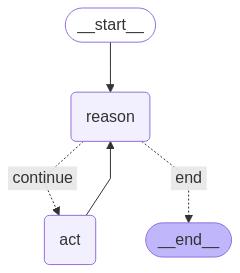

Note: Unlike the example we saw in the previous module, this compilation does not include a `checkpointer=MemorySaver()`. This means each invoke call will start with only the messages provided in the input, and the conversation history won't be automatically persisted between separate invoke calls. It runs statelessly for each invocation. This exposition focuses on the internal workings of an agent, with the discussion on memory deferred to a later stage in the module.

## Execution

The code below illustrates the execution of the single-agent system when a user input is received.

- user_input: A sample query from a user.
- messages_input: Creates the initial input for the graph, formatted as a list containing a `SystemMessage` and a `HumanMessage`. This is the starting point of the conversation for this specific execution.
- `agent_workflow.invoke(...)`: Executes the compiled graph.
    - The input is a dictionary matching the `AgentState` structure, providing the initial messages.
    - `invoke` runs the graph logic (calling agent, potentially action, looping back to agent if tools were used) until it reaches the `END` state.
    - It returns the final state of the graph after execution completes.
- `final_ai_message = response['messages'][-1].content`: Extracts the content of the last message from the final state's message list. This is typically the AI's final response to the user's initial query after any necessary tool calls.
- `print(final_ai_message)`: Displays the extracted final AI response.

In [40]:
system_prompt = """
You are a friendly and highly capable AI customer support assistant for an online retailer.
Your primary function is to help customers with common issues.
You have access to tools for checking order status, product inventory, initiating returns, and escalating complex cases.
Analyze the customer's query carefully. If it matches a tool's capability (like checking order 'ORD123' status, checking stock for 'KBD003', or returning 'MSE002' from order 'ORD123' due to 'defect'), use the appropriate tool.
Remember that more than one tool might be necessary to address complex queries.
If the query is complex, requires information not available via tools, use the escalation tool. Provide clear and concise answers based on the tool results or inform the customer about the escalation.

Your final output should be a direct and helpful response to the customer addressing their query.
This response should either contain the information requested (e.g., order status, stock level), confirm the action taken (e.g., return initiated with ID), or confirm escalation (with ticket ID)."
"""

In [41]:
user_input = "Hi, can you tell me the status of my order ORD123?"

messages_input = [SystemMessage(content=system_prompt), HumanMessage(content=user_input)]

In [42]:
response = agent_workflow.invoke({"messages": messages_input})

---LLM NODE---
--- Condition: should_continue ---
Decision: Continue to action node
--- Tool: get_order_details --- Input: order_id='ORD123'
---LLM NODE---
--- Condition: should_continue ---
Decision: End graph


In [43]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

Your order **ORD123** has been shipped. It includes the following items: **Laptop** and **Mouse**. The shipping address is **123 Main St.** You can track your order using the tracking number **TRK456**. If you have any more questions, feel free to ask!


We can inspect the entire trace of messages executed by the agent as we did in approach 1.

In [44]:
for message in response['messages']:
    message.pretty_print()

================================ System Message ================================


You are a friendly and highly capable AI customer support assistant for an online retailer.
Your primary function is to help customers with common issues.
You have access to tools for checking order status, product inventory, initiating returns, and escalating complex cases.
Analyze the customer's query carefully. If it matches a tool's capability (like checking order 'ORD123' status, checking stock for 'KBD003', or returning 'MSE002' from order 'ORD123' due to 'defect'), use the appropriate tool.
Remember that more than one tool might be necessary to address complex queries.
If the query is complex, requires information not available via tools, use the escalation tool. Provide clear and concise answers based on the tool results or inform the customer about the escalation.

Your final output should be a direct and helpful response to the customer addressing their query.
This response should either contai

Let us look at another example.

In [45]:
user_input = "I want to return the mouse (MSE002) from order ORD123 because it's faulty."

messages_input = [SystemMessage(content=system_prompt), HumanMessage(content=user_input)]

In [46]:
response = agent_workflow.invoke({"messages": messages_input})

---LLM NODE---
--- Condition: should_continue ---
Decision: Continue to action node
--- Tool: initiate_return --- Input: order_id='ORD123', sku='MSE002', reason='faulty'
---LLM NODE---
--- Condition: should_continue ---
Decision: End graph


In [47]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

Your return for the mouse (SKU: MSE002) from order ORD123 has been successfully initiated due to it being faulty. Your return ID is RMA-4282AC. Instructions for the return will be emailed to you shortly. If you have any further questions, feel free to ask!


In [48]:
for message in response['messages']:
    message.pretty_print()

================================ System Message ================================


You are a friendly and highly capable AI customer support assistant for an online retailer.
Your primary function is to help customers with common issues.
You have access to tools for checking order status, product inventory, initiating returns, and escalating complex cases.
Analyze the customer's query carefully. If it matches a tool's capability (like checking order 'ORD123' status, checking stock for 'KBD003', or returning 'MSE002' from order 'ORD123' due to 'defect'), use the appropriate tool.
Remember that more than one tool might be necessary to address complex queries.
If the query is complex, requires information not available via tools, use the escalation tool. Provide clear and concise answers based on the tool results or inform the customer about the escalation.

Your final output should be a direct and helpful response to the customer addressing their query.
This response should either contai

Finally, let us look at the compound query we executed in approach 1.

In [49]:
user_input = """
Hi, I need to return the Keyboard (SKU KBD003) from my order ORD456 because it arrived broken.
Can you please start that process?
Also, I'd like to order a replacement - could you check if the Keyboard (KBD003) is currently in stock?
"""

messages_input = [SystemMessage(content=system_prompt), HumanMessage(content=user_input)]

In [50]:
response = agent.invoke({"messages": messages_input})

--- Tool: initiate_return --- Input: order_id='ORD456', sku='KBD003', reason='defect'--- Tool: check_product_inventory --- Input: sku='KBD003'



In [51]:
final_ai_message = response['messages'][-1].content
print(final_ai_message)

I've initiated the return process for the Keyboard (SKU KBD003) from your order ORD456 due to it arriving broken. Your return ID is RMA-4000C0, and you will receive instructions via email shortly.

However, I checked the availability for a replacement Keyboard (KBD003), and unfortunately, it is currently out of stock. If you have any other questions or need further assistance, feel free to ask!


In [52]:
for message in response['messages']:
    message.pretty_print()

================================ System Message ================================


You are a friendly and highly capable AI customer support assistant for an online retailer.
Your primary function is to help customers with common issues.
You have access to tools for checking order status, product inventory, initiating returns, and escalating complex cases.
Analyze the customer's query carefully. If it matches a tool's capability (like checking order 'ORD123' status, checking stock for 'KBD003', or returning 'MSE002' from order 'ORD123' due to 'defect'), use the appropriate tool.
Remember that more than one tool might be necessary to address complex queries.
If the query is complex, requires information not available via tools, use the escalation tool. Provide clear and concise answers based on the tool results or inform the customer about the escalation.

Your final output should be a direct and helpful response to the customer addressing their query.
This response should either contai